<a href="https://colab.research.google.com/github/naguzmans/opportunistic-atm/blob/master/spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install pyspark
!pip install haversine
%cd /content/drive/MyDrive/opportunistic-utm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/drive/MyDrive/opportunistic-utm


# Load CSV data into Spark

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, BooleanType, LongType, DateType, IntegerType
from pyspark.sql.functions import udf
import os
import glob
import datetime
from haversine import haversine, Unit, inverse_haversine
import numpy as np

airport = (51.871496514, -0.367665196) # Luton
diag_distance = 25
min_coord = inverse_haversine(airport, diag_distance, np.pi * 1.25)
max_coord = inverse_haversine(airport, diag_distance, np.pi * .25)
min_lat, max_lat, min_lon, max_lon = (min_coord[0], max_coord[0], min_coord[1], max_coord[1])

spark = SparkSession.builder.appName('opensky').getOrCreate()
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

schema = StructType([ \
    StructField('time', LongType(), False), \
    StructField('icao24', StringType(), True), \
    StructField('lat', FloatType(), True), \
    StructField('lon', FloatType(), True), \
    StructField('velocity', FloatType(), True), \
    StructField('heading', FloatType(), True), \
    StructField('vertrate', FloatType(), True), \
    StructField('callsign', StringType(), True), \
    StructField('onground', BooleanType(), True), \
    StructField('alert', BooleanType(), True), \
    StructField('spi', BooleanType(), True), \
    StructField('squawk', FloatType(), True), \
    StructField('baroaltitude', FloatType(), True), \
    StructField('geoaltitude', FloatType(), True), \
    StructField('lastposupdate', FloatType(), True), \
    StructField('lastcontact', FloatType(), True), \
    StructField('hour', LongType(), True) \
])

def epoch_to_utc(hour_in_unix_time):
  return datetime.datetime.utcfromtimestamp(hour_in_unix_time)
utc = udf(epoch_to_utc, DateType())

folder_path = '/content/drive/MyDrive/opportunistic-utm/data'
file_names = []

for filename in glob.iglob(folder_path + '/**/*.csv', recursive=True):
  file_names.append(filename)

opensky_df = spark.read.option('header', True).csv(path=file_names, schema=schema)
opensky_df = opensky_df.withColumn('timestamp', utc('hour'))

# opensky_df = opensky_df.sort('time')
opensky_df.show(10)

+----------+------+---------+------------+--------+---------+--------+--------+--------+-----+-----+------+------------+-----------+-------------+-----------+----------+----------+
|      time|icao24|      lat|         lon|velocity|  heading|vertrate|callsign|onground|alert|  spi|squawk|baroaltitude|geoaltitude|lastposupdate|lastcontact|      hour| timestamp|
+----------+------+---------+------------+--------+---------+--------+--------+--------+-----+-----+------+------------+-----------+-------------+-----------+----------+----------+
|1497139225|400755|51.918453| -0.11943708| 72.8715|255.27702|-3.90144|  TOM6VY|   false|false|false|7774.0|     1005.84|     998.22|  1.4971392E9|1.4971392E9|1497139200|2017-06-11|
|1497139226|400755|51.918274| -0.12046814|72.37406|255.17352|-3.90144|  TOM6VY|   false|false|false|7774.0|     1005.84|     998.22|  1.4971392E9|1.4971392E9|1497139200|2017-06-11|
|1497139227|400755|51.918083|-0.121398926|72.37406|255.17352|-3.90144|  TOM6VY|   false|false|f

In [ ]:
opensky_df.printSchema()

root
 |-- time: long (nullable = true)
 |-- icao24: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- lon: float (nullable = true)
 |-- velocity: float (nullable = true)
 |-- heading: float (nullable = true)
 |-- vertrate: float (nullable = true)
 |-- callsign: string (nullable = true)
 |-- onground: boolean (nullable = true)
 |-- alert: boolean (nullable = true)
 |-- spi: boolean (nullable = true)
 |-- squawk: float (nullable = true)
 |-- baroaltitude: float (nullable = true)
 |-- geoaltitude: float (nullable = true)
 |-- lastposupdate: float (nullable = true)
 |-- lastcontact: float (nullable = true)
 |-- hour: long (nullable = true)
 |-- timestamp: date (nullable = true)



In [ ]:
print((opensky_df.count(), len(opensky_df.columns)))

(73780207, 17)


# Plot hourly data

In [ ]:
from pyspark.sql.functions import countDistinct
import matplotlib.pyplot as plt
from pyspark.sql.functions import days
%config InlineBackend.figure_format = 'retina'

subset = opensky_df.groupBy('timestamp').agg(countDistinct('icao24'))
df = subset.toPandas()
df = df.sort_values(by=['timestamp']).reset_index(drop=True)

In [ ]:
df.head()

,timestamp,count(icao24)
0,2017-01-01,89
1,2017-01-02,126
2,2017-01-03,105
3,2017-01-04,102
4,2017-01-05,98


Text(0.5, 1.0, 'Luton Airport Area - Number of Daily Flights')

<Figure size 432x288 with 0 Axes>

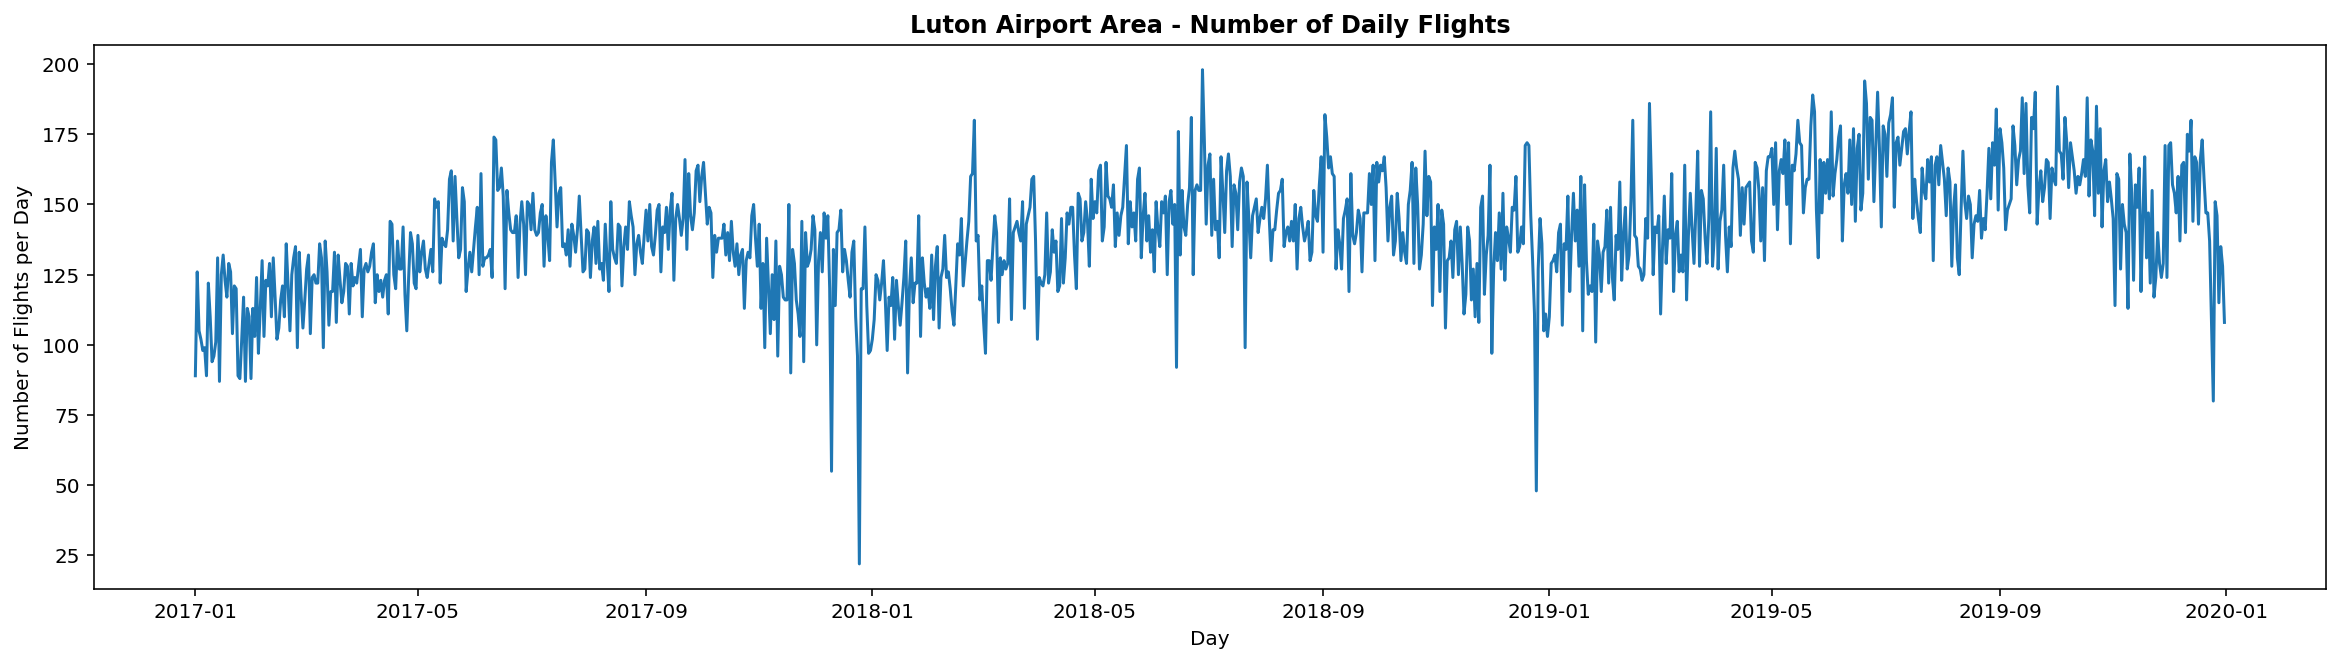

In [ ]:
plt.figure()
fig, ax = plt.subplots(figsize=(20,5))

ax.plot(df['timestamp'], df['count(icao24)'])
ax.set_xlabel('Day')
ax.set_ylabel('Number of Flights per Day')
ax.set_title('Luton Airport Area - Number of Daily Flights', fontweight='bold')

# Grid data

In [ ]:
datetime(2019, 12, 13, 6, 0, 0).replace(tzinfo=timezone.utc).timestamp()

1576216800.0

In [ ]:
np.linspace(3,31,29)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31.])

In [ ]:
from datetime import timezone
from datetime import datetime
from haversine import haversine, Unit, inverse_haversine
from pyspark.sql.functions import udf
from pyspark.sql.types import StructType, StructField, StringType, FloatType, BooleanType, LongType, DateType, IntegerType
import math
from pyspark.sql.functions import count
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import numpy as np
%config InlineBackend.figure_format = 'retina'
from IPython.display import clear_output
import os
from subsampler import subsampler

# Calculate distances to airport
airport = (51.87626460000001, -0.3717470999999932) # Luton
diag_distance = 3.5
min_coord = inverse_haversine(airport, diag_distance, np.pi * 1.25)
max_coord = inverse_haversine(airport, diag_distance, np.pi * .25)
min_lat, max_lat, min_lon, max_lon = (min_coord[0], max_coord[0], min_coord[1], max_coord[1])

# Query
year = 2019
month = 1
days = np.linspace(1,31,31)
grid_size = 50

for day in tqdm(days):
  hour_start = datetime(year, month, int(day), 0, 0, 0).replace(tzinfo=timezone.utc).timestamp()
  hour_end = datetime(year, month, int(day), 23, 59, 59).replace(tzinfo=timezone.utc).timestamp()

  day_subset = opensky_df.where(
                                # (opensky_df.hour >= start_day) & 
                                # (opensky_df.hour <= end_day) &
                                (opensky_df.lat >= min_lat) &
                                (opensky_df.lat < max_lat) &
                                (opensky_df.lon >= min_lon) &
                                (opensky_df.lon < max_lon) &
                                (opensky_df.geoaltitude >= 0) & 
                                (opensky_df.geoaltitude < 1000) &
                                (opensky_df.hour >= hour_start) &
                                (opensky_df.hour <= hour_end)
                              )

  # def epoch_to_utc(hour_in_unix_time):
  #   return datetime.datetime.utcfromtimestamp(hour_in_unix_time)
  # utc = udf(epoch_to_utc, DateType())

  def calculate_west_east_distance(destination_longitude):
    return haversine(min_coord, (min_coord[0], destination_longitude), unit=Unit.METERS) # (lat, lon)
  we_distance = udf(calculate_west_east_distance, FloatType())

  def calculate_north_south_distance(destination_latitude):
    return haversine(min_coord, (destination_latitude, min_coord[1]), unit=Unit.METERS) # (lat, lon)
  ns_distance = udf(calculate_north_south_distance, FloatType())

  def calculate_pixel_distance(destination_distance):
    return math.floor(destination_distance/grid_size)
  px_distance = udf(calculate_pixel_distance, IntegerType())

  def calculate_pixel_altitude(destination_altitude):
    altitude_level = math.floor((destination_altitude-160)/grid_size)
    if altitude_level >= 0:
      return altitude_level
    else:
      return 0
  px_altitude = udf(calculate_pixel_altitude, IntegerType())

  # opensky_df = opensky_df.withColumn('timestamp', utc('hour'))
  # opensky_df = opensky_df.withColumn('altitude', ft_to_m('geoaltitude'))
  day_subset = day_subset.withColumn('we_distance', we_distance('lon'))
  day_subset = day_subset.withColumn('ns_distance', ns_distance('lat'))
  day_subset = day_subset.withColumn('we_px', px_distance('we_distance'))
  day_subset = day_subset.withColumn('ns_px', px_distance('ns_distance'))
  day_subset = day_subset.withColumn('alt_px', px_altitude('geoaltitude'))

  # print((day_subset.count(), len(day_subset.columns)))
  # day_subset.show(10)


  epoch_hour = hour_start # start hour
  # hour_subset = subsampler(day_subset.toPandas()).groupby(['hour', 'alt_px', 'ns_px', 'we_px']).agg({'callsign': 'count'}).reset_index()
  hour_subset = day_subset.toPandas()

  cmap = plt.cm.get_cmap('brg', 10)
  for i in range(0, 24):
    matrix = np.zeros((16,100,100))

    image_subset = hour_subset[hour_subset['hour'] == epoch_hour].reset_index(drop=True)
    # image_subset = image_subset.groupby(['alt_px', 'ns_px', 'we_px']).agg({'icao24': 'count'}).reset_index()
    callsigns = image_subset.groupby('callsign')['time'].count().reset_index()['callsign'].tolist()
    try: # Some image_subset could be 0 length
      for callsign in callsigns:
        callsign_filtered = image_subset[image_subset['callsign'] == callsign].reset_index(drop=True)
        callsign_filtered = subsampler(callsign_filtered, 50)
        for j in range(0, len(callsign_filtered)):
          matrix[callsign_filtered['alt_px'][j]][callsign_filtered['ns_px'][j]][callsign_filtered['we_px'][j]] = 1
    except:
      pass
    
    # cmap = mpl.colors.ListedColormap(['black','white', 'blue', 'green', 'yellow'])
    max_matrix = np.amax(matrix, axis = 0)
    img = plt.imshow(max_matrix, cmap = plt.get_cmap('plasma'), origin='lower')
    plt.show()
    
    # Save
    working_folder = f'/content/drive/MyDrive/opportunistic-utm/dataset/{year}-{str(month).zfill(2)}/{year}-{str(month).zfill(2)}-{str(int(day)).zfill(2)}'

    if not os.path.exists(f'{working_folder}'):
      os.makedirs(f'{working_folder}')

    if not os.path.exists(f'{working_folder}/img'):
      os.makedirs(f'{working_folder}/img')
    
    np.save(f'{working_folder}/{int(epoch_hour)}.npy', matrix)
    plt.imsave(f'{working_folder}/img/{int(epoch_hour)}.png', max_matrix, origin='lower')

    print(f'\nCompleted: {int(epoch_hour)}')
    epoch_hour += 3600


# Visualize map

In [ ]:
!pip install contextily
!pip install pyproj

In [22]:
from datetime import timezone
from datetime import datetime
import math
import numpy as np
from haversine import haversine, Unit, inverse_haversine

# Calculate distances to airport
airport = (51.87626460000001, -0.3717470999999932) # Luton
diag_distance = 3.5
min_coord = inverse_haversine(airport, diag_distance, np.pi * 1.25)
max_coord = inverse_haversine(airport, diag_distance, np.pi * .25)
min_lat, max_lat, min_lon, max_lon = (min_coord[0], max_coord[0], min_coord[1], max_coord[1])

year = 2019
month = 1
day = 22

hour_lookup = 1548154800
grid_size = 50

hour_start = datetime(year, month, day, 0, 0, 0).replace(tzinfo=timezone.utc).timestamp()
hour_end = datetime(year, month, day, 23, 59, 59).replace(tzinfo=timezone.utc).timestamp()

day_subset = opensky_df.where(
                              (opensky_df.lat >= min_lat) &
                              (opensky_df.lat < max_lat) &
                              (opensky_df.lon >= min_lon) &
                              (opensky_df.lon < max_lon) &
                              (opensky_df.geoaltitude >= 0) & 
                              (opensky_df.geoaltitude < 1000) &
                              (opensky_df.hour >= hour_start) &
                              (opensky_df.hour <= hour_end)
                            )
def calculate_west_east_distance(destination_longitude):
  return haversine(min_coord, (min_coord[0], destination_longitude), unit=Unit.METERS) # (lat, lon)
we_distance = udf(calculate_west_east_distance, FloatType())

def calculate_north_south_distance(destination_latitude):
  return haversine(min_coord, (destination_latitude, min_coord[1]), unit=Unit.METERS) # (lat, lon)
ns_distance = udf(calculate_north_south_distance, FloatType())

def calculate_pixel_distance(destination_distance):
  return math.floor(destination_distance/grid_size)
px_distance = udf(calculate_pixel_distance, IntegerType())

def calculate_pixel_altitude(destination_altitude):
  altitude_level = math.floor((destination_altitude-160)/grid_size)
  if altitude_level >= 0:
    return altitude_level
  else:
    return 0

px_altitude = udf(calculate_pixel_altitude, IntegerType())

# opensky_df = opensky_df.withColumn('timestamp', utc('hour'))
# opensky_df = opensky_df.withColumn('altitude', ft_to_m('geoaltitude'))
day_subset = day_subset.withColumn('we_distance', we_distance('lon'))
day_subset = day_subset.withColumn('ns_distance', ns_distance('lat'))
day_subset = day_subset.withColumn('we_px', px_distance('we_distance'))
day_subset = day_subset.withColumn('ns_px', px_distance('ns_distance'))
day_subset = day_subset.withColumn('alt_px', px_altitude('geoaltitude'))

pd_image_subset = day_subset.where(day_subset.hour == hour_lookup).toPandas()

In [23]:
pd_image_subset.head()

,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,...,geoaltitude,lastposupdate,lastcontact,hour,timestamp,we_distance,ns_distance,we_px,ns_px,alt_px
0,1548154898,40720a,51.872772,-0.379399,73.278931,254.109848,15.280640,EDC268R,False,False,...,281.940002,1.548155e+09,1.548155e+09,1548154800,2019-01-22,1949.296265,2087.150146,38,41,2
1,1548154899,40720a,51.872772,-0.379399,73.278931,254.109848,16.256001,EDC268R,False,False,...,297.179993,1.548155e+09,1.548155e+09,1548154800,2019-01-22,1949.296265,2087.150146,38,41,2
2,1548154900,40720a,51.872360,-0.381849,73.278931,254.109848,16.256001,EDC268R,False,False,...,297.179993,1.548155e+09,1.548155e+09,1548154800,2019-01-22,1781.049683,2041.339111,35,40,2
3,1548154901,40720a,51.872131,-0.383037,72.148819,254.279068,17.556480,EDC268R,False,False,...,327.660004,1.548155e+09,1.548155e+09,1548154800,2019-01-22,1699.475708,2015.888550,33,40,3
4,1548154902,40720a,51.872131,-0.383037,72.011139,254.673080,17.556480,EDC268R,False,False,...,350.519989,1.548155e+09,1.548155e+09,1548154800,2019-01-22,1699.475708,2015.888550,33,40,3


In [24]:
np.max(pd_image_subset['geoaltitude'])

762.0

In [25]:
callsigns = pd_image_subset.groupby('callsign')['time'].count().reset_index()['callsign'].tolist()
callsigns

['BMS7SE', 'EDC268R', 'EZY45AD', 'EZY54WK', 'NJE360F', 'WUK97']

<Figure size 432x288 with 0 Axes>

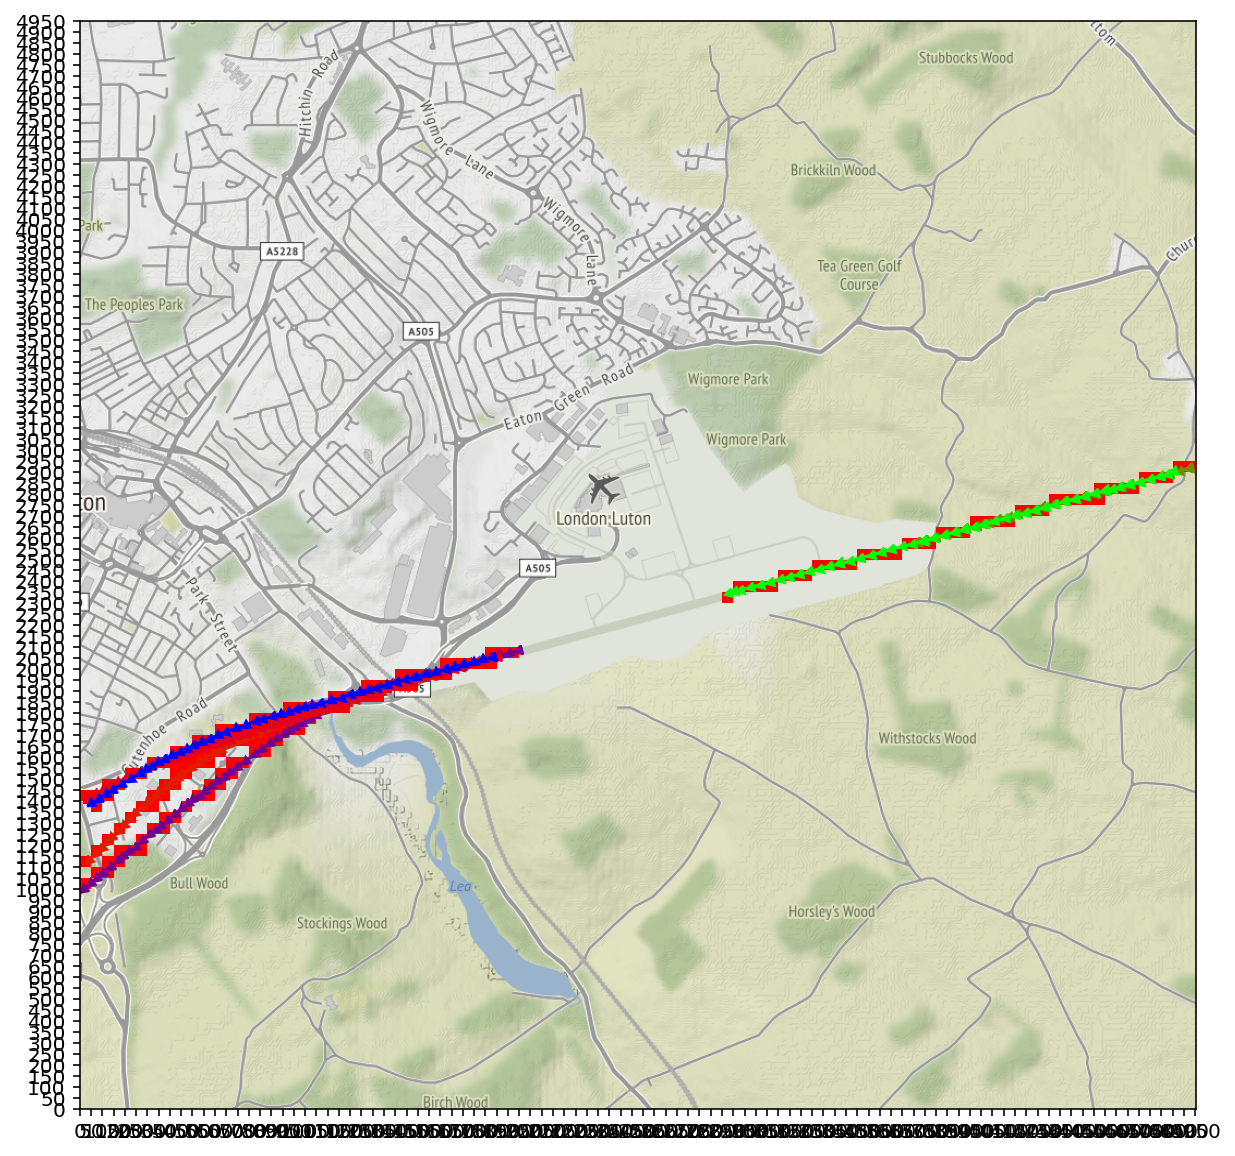

In [27]:
import contextily as cx
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import random
from subsampler import subsampler
%config InlineBackend.figure_format = 'retina'

plt.figure()
fig, ax = plt.subplots(figsize=(10,10))

ghent_img, ghent_ext = cx.bounds2img(min_lon, min_lat, max_lon, max_lat, ll=True, source=cx.providers.Stamen.Terrain)
we_distance = haversine(min_coord, (min_lat, max_lon), unit=Unit.METERS)
ns_distance = haversine(min_coord, (max_lat, min_lon), unit=Unit.METERS)

ax.imshow(ghent_img, extent=(0, we_distance, 0, ns_distance))

cmap = plt.cm.get_cmap('brg', 10)
for callsign in callsigns:
  callsign_subset = pd_image_subset[pd_image_subset['callsign'] == callsign].reset_index(drop=True)
  callsign_subset = subsampler(callsign_subset, 50)
  color_index = random.randint(0, 10)
  ax.plot(callsign_subset['we_distance'], callsign_subset['ns_distance'], color=cmap(color_index))

  for k in range(0, len(callsign_subset)):
    ax.plot(callsign_subset['we_distance'][k], callsign_subset['ns_distance'][k], '-', marker=(3, 0, -callsign_subset['heading'][k]), markersize=5, color = cmap(color_index))
    rect = patches.Rectangle((callsign_subset['we_px'][k]*grid_size, callsign_subset['ns_px'][k]*grid_size), grid_size, grid_size, facecolor='red', alpha=1)
    ax.add_patch(rect)

ax.set_xticks(np.arange(0, 5000, grid_size))
ax.set_yticks(np.arange(0, 5000, grid_size))
# ax.grid(color='black', linewidth = 1, which='both')
ax.set_aspect('auto')
# ax.axis('off')

In [6]:
callsign_subset

,time,icao24,lat,lon,velocity,heading,vertrate,callsign,onground,alert,...,geoaltitude,lastposupdate,lastcontact,hour,timestamp,we_distance,ns_distance,we_px,ns_px,alt_px
0,1546358888,40750d,51.875771,-0.361955,52.293934,254.596573,0.65024,WZZ646,False,False,...,205.740005,1.546359e+09,1.546359e+09,1546358400,2019-01-01,3147.411621,2420.552002,62,48,0
1,1546358888.333333,40750d,51.866592,-0.407608,83.214401,237.881973,12.67968,WZZ646,False,False,...,205.740005,0.000000e+00,1.546359e+09,1546358400,2019-01-01,3108.324463,2409.523438,62,48,0
2,1546358888.666667,40750d,51.866592,-0.407608,83.214401,237.881973,12.67968,WZZ646,False,False,...,205.740005,0.000000e+00,1.546359e+09,1546358400,2019-01-01,3069.237549,2398.494873,61,47,0
3,1546358889,40750d,51.875473,-0.363662,52.293934,254.596573,0.65024,WZZ646,False,False,...,205.740005,1.546359e+09,1.546359e+09,1546358400,2019-01-01,3030.150391,2387.466309,60,47,0
4,1546358890,40750d,51.875473,-0.363662,54.552898,254.128815,0.32512,WZZ646,False,False,...,213.360001,1.546359e+09,1.546359e+09,1546358400,2019-01-01,3030.150391,2387.466309,60,47,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1546358928.333333,40750d,51.866592,-0.407608,83.214401,237.881973,12.67968,WZZ646,False,False,...,535.940002,0.000000e+00,1.546359e+09,1546358400,2019-01-01,152.876709,1496.980469,3,29,7
87,1546358928.666667,40750d,51.866592,-0.407608,83.214401,237.881973,12.67968,WZZ646,False,False,...,538.480042,0.000000e+00,1.546359e+09,1546358400,2019-01-01,115.394417,1471.812622,2,29,7
88,1546358929,40750d,51.867012,-0.406647,83.214401,237.881973,12.67968,WZZ646,False,False,...,541.020020,1.546359e+09,1.546359e+09,1546358400,2019-01-01,77.912125,1446.644897,1,28,7
89,1546358929.5,40750d,51.866592,-0.407608,83.214401,237.881973,12.67968,WZZ646,False,False,...,537.210022,0.000000e+00,1.546359e+09,1546358400,2019-01-01,44.914524,1423.315186,0,28,7
